# Introduction

Our notebooks have been initialized thanks to several sources provided around the Home Credit default risk [Kaggle](https://www.kaggle.com/c/home-credit-default-risk) competition: data from Home Credit, Kernels-Notebooks from competitors, Discussions threads involving host and competitors.

While the objective of competitors is to get the best AUC score _Area under the ROC Curve_ by *__any means__*, we'll rather focuse on the ability to provide *__interpretable__* decisions, including the possibility given to customers to explore their case.

# Notebooks & dashboard

There are 4 different notebooks:
* __P7_EDA__: focusing on Exploratory Data Analysis,
* __Current : P7_FE__: focusing on Feature Engineering
* __P7_FS__: model-agnostic Feature Selection,
* __P7_Model__: focusing on scoring & model evaluation,
* __P7_Interpretation__ : focusing on model interpretation,
And a dashboard python file.


# Data

This diagram shows data relationship :

<img src="https://storage.googleapis.com/kaggle-media/competitions/home-credit/home_credit.png" class="svg" alt="" width="700" height="700">

There are 7 different sources of data:
Current application:
* __application__: details about each `SK_ID_CURR` loan application and applicant + `TARGET` indicating the risk of failure to repay loan on time.
* __test__: where the `TARGET` has not been calculated yet.

External previous credits information:
* __bureau__: details about each `SK_ID_BUREAU` client's previous credits oustide our company, with cardinality 1:n from current application.
* __bureau_balance__: monthly details of each `SK_ID_BUREAU`.
Internal previous credit information:
* __previous_application__: details about each `SK_ID_PREV` client's previous credits applications within our company, with cardinality 1:n from current application.
* __POS_CASH_balance__: monthly details of each `SK_ID_PREV` (credits or cash types).
* __credit_card_balance__: monthly details of each `SK_ID_PREV` (credit cards revolving type).
* __installments_payment__: payment history of each `SK_ID_PREV`.

Moreover, we are provided with the features definitions (in `HomeCredit_columns_description.csv`). 

# Forewords

In this FE notebook, we process datasets aggregation in order to get to an intermediate __fully understandable__ dataset, i.e. with any feature dealing with relevant details that could be discussed by counsellor in front of an applicant.
This will surely affect the ability to reach the amazing scores of Kaggle competitors, and it implies to spend additionnal time for FE.<br/>
Furthermore, we have to consider this task according to the expectations of the study, which consists in performing __model optimization__ and __model interpretation__. <br/>
This will lead to consider as further optional tasks many EDA & FE ideas, in order to use __model__ and its __interpretation__ bring value in that perspective. <br/>

## Imports

In [1]:
%load_ext pycodestyle_magic
%flake8_on
# PEP8 tested

In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

In [3]:
# File system manangement
import os

In [4]:
# pickle
import pickle

In [5]:
# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# custom functions
# visuals
from ipynb.fs.full.functions import plot_bar_gen, heatmap, kde_plot
# processing
from ipynb.fs.full.functions import one_hot_encoder, label_encoder
# analysis
from ipynb.fs.full.functions import target_corrs, missing_values_table
# df optimization - disabled
from ipynb.fs.full.functions import convert_types

In [7]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
# paramètres
# to display any columns
pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
sns.set(style="ticks")
sns.set_style('whitegrid')

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

## Feature Engineering as done during EDA

A fist set of transformed datasets have been dumped with pickle files, we'll load them right before using those intermediate sources.

In [10]:
# load target (for correlation study)
with open("Data/target.pkl", mode="rb") as df:
    target = pickle.load(df)

# Feature Engineering along a Bottom Up aggregation

## Aggregate over Installments

In [11]:
# third level
installments = pd.read_csv('Data/installments_payments.csv')

While every payments are detailed over any previous application SK_ID_PREV, what matters for us, somehow already accessible through both credit balance or card balance with SK_DPD, is the rough info where (i.e. when and how much) a client failed to pay the installement.

In [12]:
# alternate option would be to put that missing info as X_STATUS
installments.dropna(inplace=True)

In [13]:
installments['DAYS_INSTALMENT'].min()

-2922.0

the older installement is 8 years before current application

Let's catch overdue in time and amount :

In [14]:
# manual FE installements
# overdue amounts
installments['N_INS_AMT_OVERDUE'] = installments['AMT_INSTALMENT'] - installments['AMT_PAYMENT']
installments['N_INS_AMT_OVERDUE'] = installments['N_INS_AMT_OVERDUE'].apply(lambda x: x if x > 0 else 0)
# prepayed amounts
installments['N_INS_AMT_PREPAYED'] = installments['AMT_PAYMENT'] - installments['AMT_INSTALMENT']
installments['N_INS_AMT_PREPAYED'] = installments['N_INS_AMT_PREPAYED'].apply(lambda x: x if x > 0 else 0)
# overdue ratio
installments['N_AMT_OVERDUE_RATIO'] = installments['N_INS_AMT_OVERDUE'] / (1 + installments['AMT_INSTALMENT'])
# with positive values to get a match with SK_DPD
installments['N_INS_DPD'] = installments['DAYS_ENTRY_PAYMENT'] - installments['DAYS_INSTALMENT']
installments['N_INS_DPD'] = installments['N_INS_DPD'].apply(lambda x: x if x > 0 else 0)
# same with DBD Before Due may be somehow valuable
installments['N_INS_DBD'] = installments['DAYS_INSTALMENT'] - installments['DAYS_ENTRY_PAYMENT']
installments['N_INS_DBD'] = installments['N_INS_DBD'].apply(lambda x: x if x > 0 else 0)
# DPD categories to get a match with Bureau data
bins = [-np.inf, 1, 30, 60, 90, 120, np.inf]
values = ['0', '1', '2', '3', '4', '5']
installments['N_STATUS'] = pd.cut(installments['N_INS_DPD'], bins, labels=values)

3:80: E501 line too long (96 > 79 characters)
4:80: E501 line too long (104 > 79 characters)
6:80: E501 line too long (97 > 79 characters)
7:80: E501 line too long (106 > 79 characters)
9:80: E501 line too long (110 > 79 characters)
11:80: E501 line too long (96 > 79 characters)
12:80: E501 line too long (88 > 79 characters)
14:80: E501 line too long (96 > 79 characters)
15:80: E501 line too long (88 > 79 characters)
19:80: E501 line too long (81 > 79 characters)


In [15]:
# to get earliness of overdue we need to catch min of NUM_INSTALMENT_NUMBER out of !=0 N_STATUS
focus_installments = installments[installments['N_STATUS'] != '0']
focus_installments_agg = focus_installments.groupby(
    'SK_ID_PREV',
    as_index=False).agg(
    {'NUM_INSTALMENT_NUMBER': ['min']})
focus_installments_agg.columns = [
    'SK_ID_PREV',
    'INS_N_PREV_EARLIER_OVERDUE']

1:80: E501 line too long (95 > 79 characters)


The less this "earlier overdue" is, the more is the risk of failure. But from Null value point of view, we won't be able to set a right replacement value for clients with no overdue at all : let's first consider other aggregative data to compute a valid overdue earliness index.

In [16]:
# compute valuable features by SK_ID_PREV
installments_agg = installments.groupby(
    'SK_ID_PREV',
    as_index=False).agg(
    {'NUM_INSTALMENT_VERSION': ['max'],
     'N_INS_AMT_OVERDUE': ['max'],
     'NUM_INSTALMENT_NUMBER': ['max'],
     'DAYS_INSTALMENT': ['max']})
installments_agg.columns = [
    'SK_ID_PREV',
    'INS_N_PREV_CNT_PROLONG',
    'INS_N_PREV_INS_AMT_MAX_OVERDUE',
    'INS_N_PREV_CNT_TOT_INSTALMENT',
    'INS_N_PREV_LAST_DAYS_INSTALMENT']

In [17]:
# merge with raw earlier overdue
installments_agg = installments_agg.merge(focus_installments_agg, how='left', on='SK_ID_PREV')
# we compute a ratio with ability to fill Null with Zero after aggregation
installments_agg['INS_N_PREV_EARLINESS_OVERDUE_RATIO'] = 1 - installments_agg['INS_N_PREV_EARLIER_OVERDUE'] / installments_agg['INS_N_PREV_CNT_TOT_INSTALMENT']
installments_agg.drop(columns=['INS_N_PREV_EARLIER_OVERDUE'], inplace=True)
installments_agg['INS_N_PREV_EARLINESS_OVERDUE_RATIO'].fillna(0, inplace=True)
installments_agg['INS_N_PREV_LOAN_AGE'] = - installments_agg['INS_N_PREV_LAST_DAYS_INSTALMENT'] / 365

2:80: E501 line too long (94 > 79 characters)
4:80: E501 line too long (159 > 79 characters)
7:80: E501 line too long (101 > 79 characters)


In [18]:
installments_agg.columns

Index(['SK_ID_PREV', 'INS_N_PREV_CNT_PROLONG',
       'INS_N_PREV_INS_AMT_MAX_OVERDUE', 'INS_N_PREV_CNT_TOT_INSTALMENT',
       'INS_N_PREV_LAST_DAYS_INSTALMENT', 'INS_N_PREV_EARLINESS_OVERDUE_RATIO',
       'INS_N_PREV_LOAN_AGE'],
      dtype='object')

In [19]:
# merge with installments
installments_agg = installments_agg.merge(
    installments.filter(['SK_ID_CURR', 'SK_ID_PREV']),
    how='left',
    on='SK_ID_PREV')

In [20]:
# Preprocess installments_agg
def installments_agg_id(ins, num_rows=None, nan_as_category=True):
    # General aggregations
    ins.drop(['SK_ID_PREV'], axis=1, inplace=True)
    ins_agg = ins.groupby('SK_ID_CURR').agg(
        ['min', 'max', 'mean', 'sum', 'var'])
    ins_agg.columns = pd.Index(
        ['INSAGG_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist(
        )])
    return ins_agg

In [21]:
# installements FE by SK_ID
sk_id_installments_agg = installments_agg_id(installments_agg, num_rows=None)

In [22]:
# merge to target for corr study
ins_agg_target = target.join(sk_id_installments_agg, how='left', on='SK_ID_CURR')
ins_agg_target_corrs = target_corrs(ins_agg_target)

2:80: E501 line too long (81 > 79 characters)


In [23]:
ins_agg_target_corrs

,feature,abs_corr
21,INSAGG_INS_N_PREV_EARLINESS_OVERDUE_RATIO_MIN,0.067380
23,INSAGG_INS_N_PREV_EARLINESS_OVERDUE_RATIO_MEAN,0.061135
27,INSAGG_INS_N_PREV_LOAN_AGE_MAX,0.055247
16,INSAGG_INS_N_PREV_LAST_DAYS_INSTALMENT_MIN,0.055247
30,INSAGG_INS_N_PREV_LOAN_AGE_VAR,0.048508
20,INSAGG_INS_N_PREV_LAST_DAYS_INSTALMENT_VAR,0.048508
22,INSAGG_INS_N_PREV_EARLINESS_OVERDUE_RATIO_MAX,0.046228
6,INSAGG_INS_N_PREV_INS_AMT_MAX_OVERDUE_MIN,0.038081
19,INSAGG_INS_N_PREV_LAST_DAYS_INSTALMENT_SUM,0.037989
29,INSAGG_INS_N_PREV_LOAN_AGE_SUM,0.037989


In [24]:
del installments_agg
del focus_installments_agg

In [25]:
installments.dtypes

SK_ID_PREV                   int64
SK_ID_CURR                   int64
NUM_INSTALMENT_VERSION     float64
NUM_INSTALMENT_NUMBER        int64
DAYS_INSTALMENT            float64
DAYS_ENTRY_PAYMENT         float64
AMT_INSTALMENT             float64
AMT_PAYMENT                float64
N_INS_AMT_OVERDUE          float64
N_INS_AMT_PREPAYED         float64
N_AMT_OVERDUE_RATIO        float64
N_INS_DPD                  float64
N_INS_DBD                  float64
N_STATUS                  category
dtype: object

In [26]:
# object type represents category
installments['N_STATUS'] = installments['N_STATUS'].astype('object')

In [27]:
# Preprocess installments_payments.csv
def installments_payments(ins, num_rows=None, nan_as_category=False):
    ins, cat_cols = one_hot_encoder(ins, nan_as_category=False)
    # Features: Perform aggregations
    aggregations = {
        'DAYS_INSTALMENT': ['mean'],
        'DAYS_ENTRY_PAYMENT': ['max'],
        'N_INS_DPD': ['max', 'mean', 'sum'],
        'N_INS_DBD': ['mean'],
        'N_INS_AMT_OVERDUE': ['mean'],
        'N_AMT_OVERDUE_RATIO': ['max', 'mean'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['sum']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INS_N_INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    return ins_agg

17:80: E501 line too long (102 > 79 characters)


In [28]:
# installements FE by SK_ID
sk_id_installments = installments_payments(installments, num_rows=None)

In [29]:
del installments

In [30]:
sk_id_installments.shape

(339578, 19)

In [31]:
sk_id_installments.head(3)

,INS_DAYS_INSTALMENT_MEAN,INS_DAYS_ENTRY_PAYMENT_MAX,INS_N_INS_DPD_MAX,INS_N_INS_DPD_MEAN,INS_N_INS_DPD_SUM,INS_N_INS_DBD_MEAN,INS_N_INS_AMT_OVERDUE_MEAN,INS_N_AMT_OVERDUE_RATIO_MAX,INS_N_AMT_OVERDUE_RATIO_MEAN,INS_AMT_INSTALMENT_MAX,INS_AMT_INSTALMENT_MEAN,INS_AMT_INSTALMENT_SUM,INS_N_STATUS_0_SUM,INS_N_STATUS_1_SUM,INS_N_STATUS_2_SUM,INS_N_STATUS_3_SUM,INS_N_STATUS_4_SUM,INS_N_STATUS_5_SUM,INS_N_INSTAL_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,
100001,-2187.714286,-1628.0,11.0,1.571429,11.0,8.857143,0.0,0.0,0.0,17397.900,5885.132143,41195.925,6.0,1,0,0,0,0,7
100002,-295.000000,-49.0,0.0,0.000000,0.0,20.421053,0.0,0.0,0.0,53093.745,11559.247105,219625.695,19.0,0,0,0,0,0,19
100003,-1378.160000,-544.0,0.0,0.000000,0.0,7.160000,0.0,0.0,0.0,560835.360,64754.586000,1618864.650,25.0,0,0,0,0,0,25


In [32]:
sk_id_installments['INS_N_FAULT_RATE'] = 1 - sk_id_installments['INS_N_STATUS_0_SUM'] / sk_id_installments['INS_N_INSTAL_COUNT']

1:80: E501 line too long (128 > 79 characters)


In [33]:
sk_id_installments['INS_N_FAULT_GRAVITY'] = (
    sk_id_installments['INS_N_STATUS_1_SUM'] +
    2 * sk_id_installments['INS_N_STATUS_2_SUM'] +
    3 * sk_id_installments['INS_N_STATUS_3_SUM'] +
    4 * sk_id_installments['INS_N_STATUS_4_SUM'] +
    5 * sk_id_installments['INS_N_STATUS_5_SUM']) / sk_id_installments['INS_N_INSTAL_COUNT']

6:80: E501 line too long (92 > 79 characters)


In [34]:
sk_id_installments['INS_N_FAULT_ADJ_RATE'] = (
    1 - (sk_id_installments['INS_N_FAULT_RATE'] / -2922)) * sk_id_installments['INS_N_FAULT_RATE']

2:80: E501 line too long (98 > 79 characters)


In [35]:
sk_id_installments.drop(columns=[
    'INS_N_STATUS_1_SUM',
    'INS_N_STATUS_2_SUM',
    'INS_N_STATUS_3_SUM',
    'INS_N_STATUS_4_SUM',
    'INS_N_STATUS_5_SUM'], inplace=True)

In [36]:
# merge to target for corr study
ins_target = target.join(sk_id_installments, how='left', on='SK_ID_CURR')
ins_target_corrs = target_corrs(ins_target)

In [37]:
ins_target_corrs.head(43)

,feature,abs_corr
15,INS_N_FAULT_RATE,0.070791
17,INS_N_FAULT_ADJ_RATE,0.070790
16,INS_N_FAULT_GRAVITY,0.067062
9,INS_N_AMT_OVERDUE_RATIO_MEAN,0.063052
8,INS_N_AMT_OVERDUE_RATIO_MAX,0.045680
1,INS_DAYS_INSTALMENT_MEAN,0.043423
7,INS_N_INS_AMT_OVERDUE_MEAN,0.037576
13,INS_N_STATUS_0_SUM,0.026999
14,INS_N_INSTAL_COUNT,0.021214
6,INS_N_INS_DBD_MEAN,0.021116


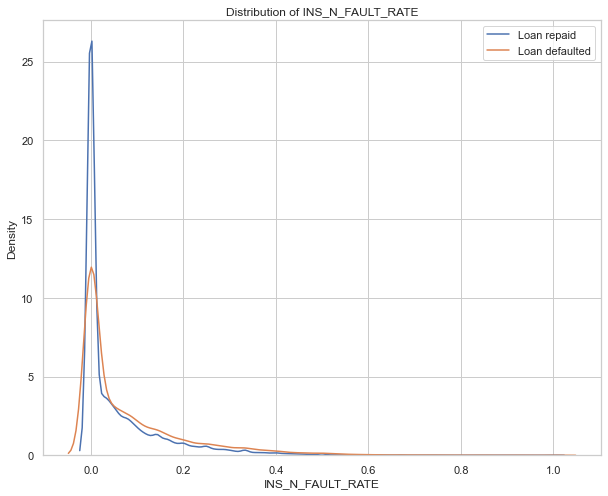

In [38]:
# most interesting feature study through plot
kde_plot(ins_target, 'INS_N_FAULT_RATE')

In [39]:
ins_target.isna().sum().head(3)

SK_ID_CURR                      0
TARGET                          0
INS_DAYS_INSTALMENT_MEAN    15876
dtype: int64

Those installments aggregative data produce missing values once merged with SK_ID, meaning we have no previous internal knowledge about those clients before application.
N_INS_INSTAL_COUNT is therefore zero for those 15876 SK_ID, and mostly nan items could here be replaced by zero.

In [40]:
sk_id_installments.isna().sum()

INS_DAYS_INSTALMENT_MEAN        0
INS_DAYS_ENTRY_PAYMENT_MAX      0
INS_N_INS_DPD_MAX               0
INS_N_INS_DPD_MEAN              0
INS_N_INS_DPD_SUM               0
INS_N_INS_DBD_MEAN              0
INS_N_INS_AMT_OVERDUE_MEAN      0
INS_N_AMT_OVERDUE_RATIO_MAX     0
INS_N_AMT_OVERDUE_RATIO_MEAN    0
INS_AMT_INSTALMENT_MAX          0
INS_AMT_INSTALMENT_MEAN         0
INS_AMT_INSTALMENT_SUM          0
INS_N_STATUS_0_SUM              0
INS_N_INSTAL_COUNT              0
INS_N_FAULT_RATE                0
INS_N_FAULT_GRAVITY             0
INS_N_FAULT_ADJ_RATE            0
dtype: int64

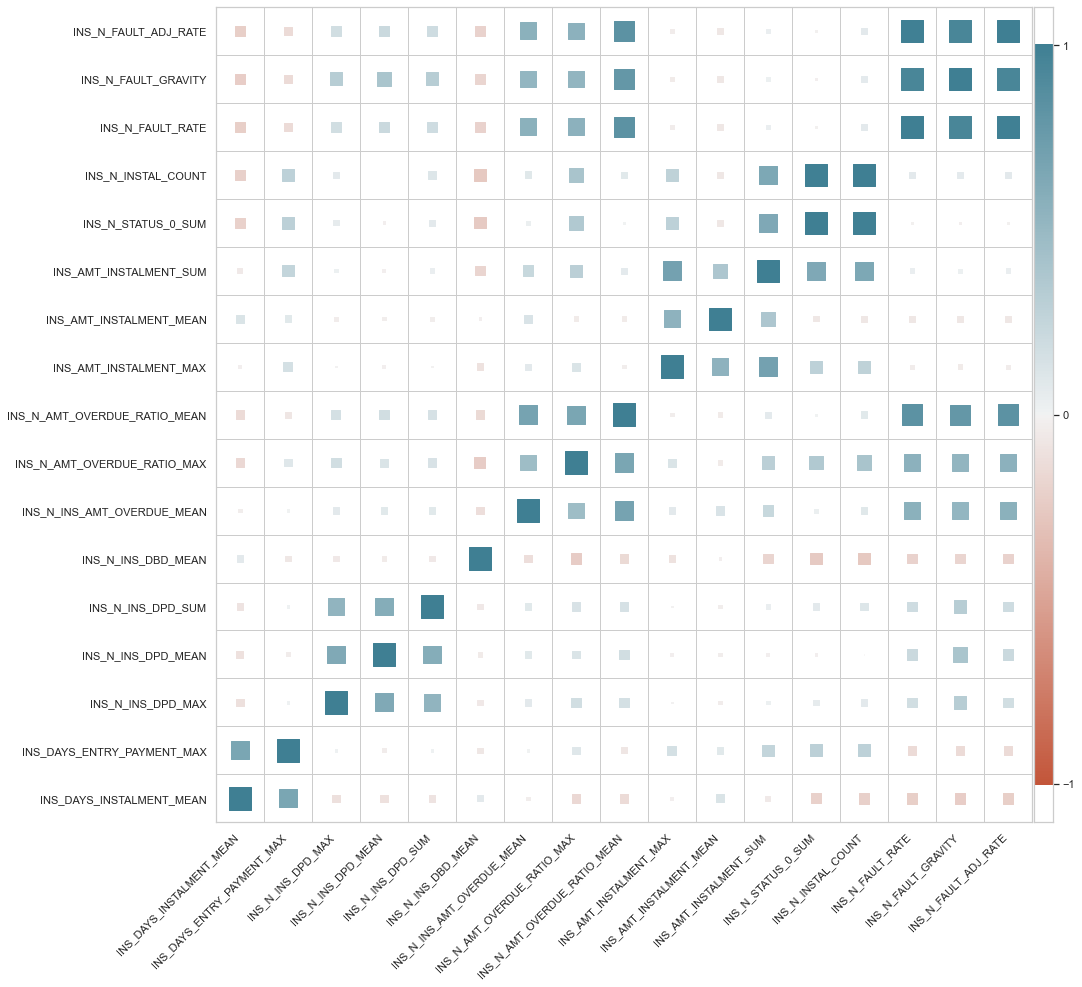

In [41]:
# calculer les corrélations entre features
corr = sk_id_installments.corr(method='pearson')
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x', 'y', 'value']
# visualiser les corrélations entre features
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

In [42]:
corr = corr[corr['value'] != 1]
corr['value'] = abs(corr['value'])
corr = corr.sort_values(by=['value'], ascending=False)
corr.head(10)

,x,y,value
254,INS_N_FAULT_ADJ_RATE,INS_N_FAULT_RATE,1.000000
286,INS_N_FAULT_RATE,INS_N_FAULT_ADJ_RATE,1.000000
233,INS_N_STATUS_0_SUM,INS_N_INSTAL_COUNT,0.992855
217,INS_N_INSTAL_COUNT,INS_N_STATUS_0_SUM,0.992855
287,INS_N_FAULT_GRAVITY,INS_N_FAULT_ADJ_RATE,0.950424
271,INS_N_FAULT_ADJ_RATE,INS_N_FAULT_GRAVITY,0.950424
269,INS_N_FAULT_RATE,INS_N_FAULT_GRAVITY,0.950422
253,INS_N_FAULT_GRAVITY,INS_N_FAULT_RATE,0.950422
246,INS_N_AMT_OVERDUE_RATIO_MEAN,INS_N_FAULT_RATE,0.838338
150,INS_N_FAULT_RATE,INS_N_AMT_OVERDUE_RATIO_MEAN,0.838338


## Aggregate over Credit balance

Credit card brings much more complex features to handle than credit, mainly because the client could use it (or not) in many ways. To get straight to the point, we'll try to catch and keep only the big picture.

In [43]:
# third level
credit_balance = pd.read_csv('Data/POS_CASH_balance.csv')

In [44]:
credit_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [45]:
# clean df and focus on active months
credit_balance.dropna(inplace=True)
credit_balance = credit_balance[credit_balance['NAME_CONTRACT_STATUS'] == 'Active']
credit_balance.drop(columns=['NAME_CONTRACT_STATUS'], inplace=True)

3:80: E501 line too long (83 > 79 characters)


In [46]:
# get an idea of filtering DPD effect
dpd_count = credit_balance[credit_balance['SK_DPD'] != 0].shape[0]
dpd_def_count = credit_balance[credit_balance['SK_DPD_DEF'] != 0].shape[0]
print('dpd_def tolerance filtering ratio: %f' %(dpd_def_count/dpd_count))

4:48: E225 missing whitespace around operator


dpd_def tolerance filtering ratio: 0.393702


Almost 40% of actual overdue are filtered, due to low laon amounts ignored.

In [47]:
# get loan age - in months and term for each previous loan
credit_balance_agg = credit_balance.groupby(
    'SK_ID_PREV',
    as_index=False).agg(
    {'MONTHS_BALANCE': ['min'],
     'CNT_INSTALMENT': ['size']})
credit_balance_agg.columns = [
    'SK_ID_PREV',
    'POS_N_PREV_LOAN_AGE_MONTH',
    'POS_N_PREV_LOAN_TERM']

In [48]:
# to get earliness of DPD overdue we need to catch min of CNT_INSTALMENT with SK_DPD > 0
dpd_credit_balance = credit_balance[credit_balance['SK_DPD'] != 0]
dpd_credit_balance_agg = dpd_credit_balance.groupby(
    'SK_ID_PREV',
    as_index=False).agg(
    {'CNT_INSTALMENT': ['min']})
dpd_credit_balance_agg.columns = [
    'SK_ID_PREV',
    'POS_N_DPD_PREV_EARLIER_OVERDUE']

1:80: E501 line too long (88 > 79 characters)


In [49]:
# to get earliness of DPD_DEF overdue we need to catch min of CNT_INSTALMENT with SK_DPD_DEF > 0
dpd_def_credit_balance = credit_balance[credit_balance['SK_DPD_DEF'] != 0]
dpd_def_credit_balance_agg = dpd_def_credit_balance.groupby(
    'SK_ID_PREV',
    as_index=False).agg(
    {'CNT_INSTALMENT': ['min']})
dpd_def_credit_balance_agg.columns = [
    'SK_ID_PREV',
    'POS_N_DPD_DEF_PREV_EARLIER_OVERDUE']

1:80: E501 line too long (96 > 79 characters)


In [50]:
# merge with raw earlier overdue
credit_balance_agg = credit_balance_agg.merge(dpd_credit_balance_agg, how='left', on='SK_ID_PREV')
credit_balance_agg = credit_balance_agg.merge(dpd_def_credit_balance_agg, how='left', on='SK_ID_PREV')

2:80: E501 line too long (98 > 79 characters)
3:80: E501 line too long (102 > 79 characters)


In [51]:
del dpd_credit_balance_agg
del dpd_def_credit_balance_agg

In [52]:
# manua FE
credit_balance_agg['POS_N_DPD_PREV_EARLINESS_OVERDUE_RATIO'] = 1 - credit_balance_agg['POS_N_DPD_PREV_EARLIER_OVERDUE'] / credit_balance_agg['POS_N_PREV_LOAN_TERM']
credit_balance_agg.drop(columns=['POS_N_DPD_PREV_EARLIER_OVERDUE'], inplace=True)
credit_balance_agg['POS_N_DPD_PREV_EARLINESS_OVERDUE_RATIO'].fillna(0, inplace=True)
credit_balance_agg['POS_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO'] = 1 - credit_balance_agg['POS_N_DPD_DEF_PREV_EARLIER_OVERDUE'] / credit_balance_agg['POS_N_PREV_LOAN_TERM']
credit_balance_agg.drop(columns=['POS_N_DPD_DEF_PREV_EARLIER_OVERDUE'], inplace=True)
credit_balance_agg['POS_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO'].fillna(0, inplace=True)
credit_balance_agg['POS_N_PREV_LOAN_AGE'] = - credit_balance_agg['POS_N_PREV_LOAN_AGE_MONTH'] / 12

2:80: E501 line too long (164 > 79 characters)
3:80: E501 line too long (81 > 79 characters)
4:80: E501 line too long (84 > 79 characters)
5:80: E501 line too long (172 > 79 characters)
6:80: E501 line too long (85 > 79 characters)
7:80: E501 line too long (88 > 79 characters)
8:80: E501 line too long (98 > 79 characters)


credit_balance_agg will be merged later on SK_ID_PREV.

In [53]:
# Preprocess POS_CASH_balance.csv
def pos_cash(pos, num_rows = None, nan_as_category=False):
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean'],
        'SK_DPD': ['min', 'max', 'mean'],
        'SK_DPD_DEF': ['min', 'max', 'mean']
    }
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_N_POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    return pos_agg

2:27: E251 unexpected spaces around keyword / parameter equals
2:29: E251 unexpected spaces around keyword / parameter equals
10:80: E501 line too long (102 > 79 characters)


In [54]:
# Preprocess POS_CASH_balance.csv
sk_id_credit_balance = pos_cash(credit_balance, num_rows=None)

In [55]:
del credit_balance

In [56]:
# merge to target for corr study
pos_target = target.join(sk_id_credit_balance, how='left', on='SK_ID_CURR')
target_corrs(pos_target)

,feature,abs_corr
9,POS_N_POS_COUNT,0.035816
2,POS_MONTHS_BALANCE_MEAN,0.033448
7,POS_SK_DPD_DEF_MAX,0.018046
8,POS_SK_DPD_DEF_MEAN,0.009336
1,POS_MONTHS_BALANCE_MAX,0.005359
3,POS_SK_DPD_MIN,0.004939
5,POS_SK_DPD_MEAN,0.004899
4,POS_SK_DPD_MAX,0.004256
6,POS_SK_DPD_DEF_MIN,0.003984
0,SK_ID_CURR,0.002108


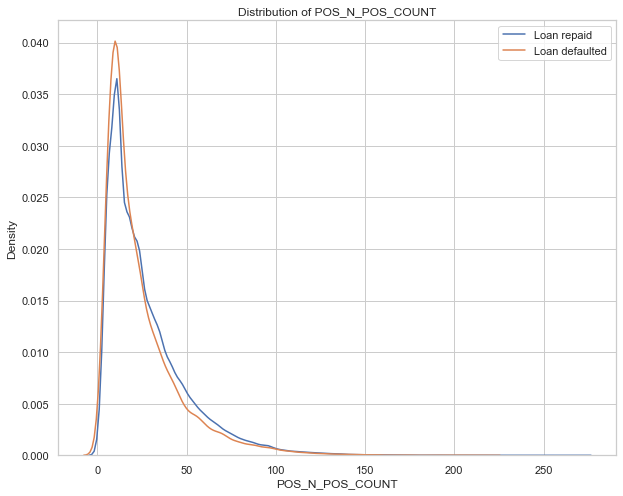

In [57]:
# most interesting feature study through plot
kde_plot(pos_target, 'POS_N_POS_COUNT')

In [58]:
pos_target.isna().sum().head(3)

SK_ID_CURR                    0
TARGET                        0
POS_MONTHS_BALANCE_MAX    18270
dtype: int64

Those pos aggregative data produce missing values once merged with SK_ID, meaning we have no previous internal knowledge about those clients before application.
POS_N_POS_COUNT is therefore zero for those 18270 SK_ID.

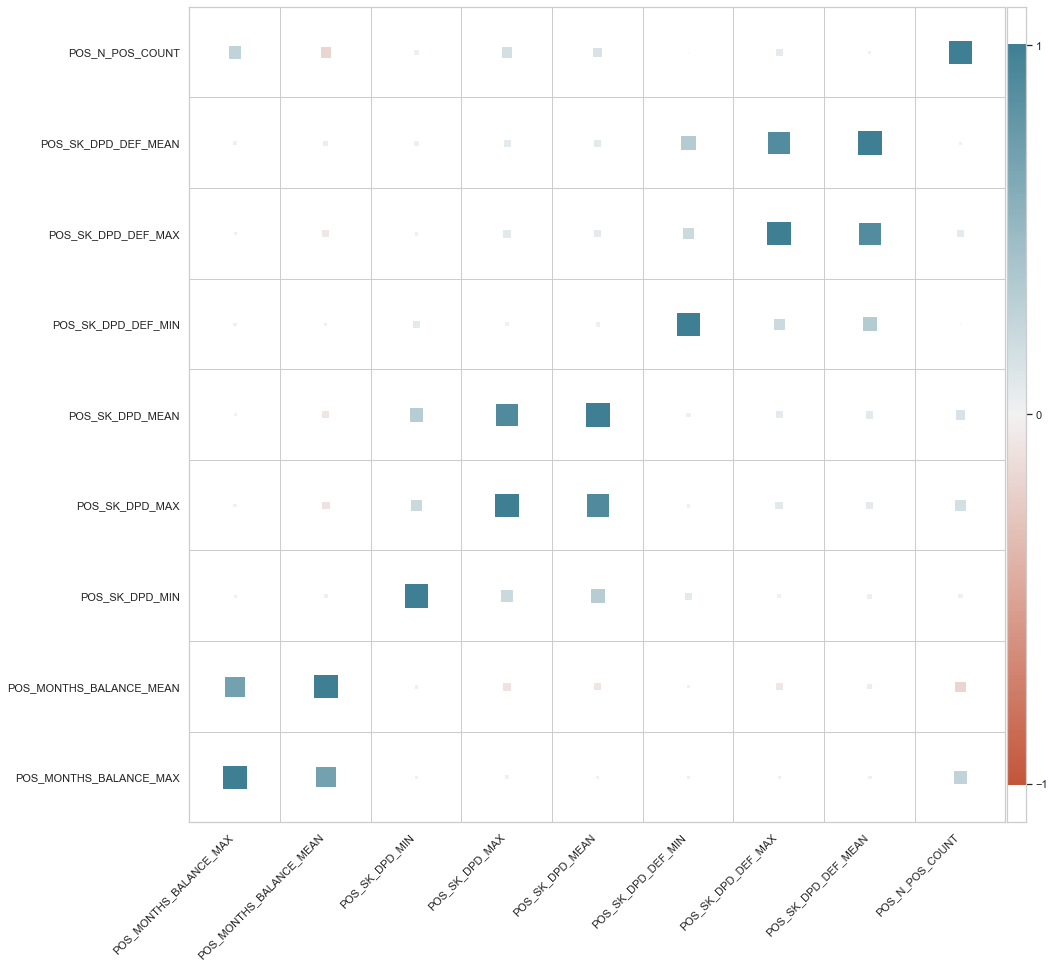

In [59]:
# calculer les corrélations entre features
corr = sk_id_credit_balance.corr(method='pearson')
corr = pd.melt(corr.reset_index(), id_vars='index')
corr.columns = ['x', 'y', 'value']
# visualiser les corrélations entre features
heatmap(
    x=corr['x'],
    y=corr['y'],
    size=corr['value'].abs(),
    color=corr['value']
)

## Aggregate over Card balance

In [60]:
# third level
card_balance = pd.read_csv('Data/credit_card_balance.csv')

In [61]:
# same with card_balance
card_balance = card_balance[card_balance['NAME_CONTRACT_STATUS'] == 'Active']

In [62]:
card_balance.drop(columns=['NAME_CONTRACT_STATUS'], inplace=True)

In [63]:
card_balance.fillna(0, inplace=True)

In [64]:
# filtering effect
card_dpd_count = card_balance[card_balance['SK_DPD'] != 0].shape[0]
card_dpd_def_count = card_balance[card_balance['SK_DPD_DEF'] != 0].shape[0]
print('dpd_def tolerance filtering ratio: ',
      round(100 * (card_dpd_def_count/card_dpd_count), 2))

dpd_def tolerance filtering ratio:  57.89


Tolerance level seems higher for credit card overdue.

In [65]:
# get loan age - in months and term for each previous loan
card_balance_agg = card_balance.groupby(
    'SK_ID_PREV',
    as_index=False).agg(
    {'MONTHS_BALANCE': ['min', 'size']})
card_balance_agg.columns = [
    'SK_ID_PREV',
    'CC_N_PREV_LOAN_AGE_MONTH',
    'CC_N_PREV_LOAN_TERM']

In [66]:
# to get earliness of DPD overdue we need to catch min of CNT_INSTALMENT with SK_DPD > 0
dpd_card_balance = card_balance[card_balance['SK_DPD'] != 0]
dpd_card_balance_agg = dpd_card_balance.groupby(
    'SK_ID_PREV',
    as_index=False).agg(
    {'MONTHS_BALANCE': ['min']})
dpd_card_balance_agg.columns = [
    'SK_ID_PREV',
    'CC_N_DPD_PREV_EARLIER_OVERDUE']

1:80: E501 line too long (88 > 79 characters)


In [67]:
# to get earliness of DPD_DEF overdue we need to catch min of CNT_INSTALMENT with SK_DPD_DEF > 0
dpd_def_card_balance = card_balance[card_balance['SK_DPD_DEF'] != 0]
dpd_def_card_balance_agg = dpd_def_card_balance.groupby(
    'SK_ID_PREV',
    as_index=False).agg(
    {'MONTHS_BALANCE': ['min']})
dpd_def_card_balance_agg.columns = [
    'SK_ID_PREV',
    'CC_N_DPD_DEF_PREV_EARLIER_OVERDUE']

1:80: E501 line too long (96 > 79 characters)


In [68]:
# merge with raw earlier overdue
card_balance_agg = card_balance_agg.merge(dpd_card_balance_agg, how='left', on='SK_ID_PREV')
card_balance_agg = card_balance_agg.merge(dpd_def_card_balance_agg, how='left', on='SK_ID_PREV')

2:80: E501 line too long (92 > 79 characters)
3:80: E501 line too long (96 > 79 characters)


In [69]:
del dpd_card_balance_agg
del dpd_def_card_balance_agg

In [70]:
# manual FE
card_balance_agg['CC_N_DPD_PREV_EARLINESS_OVERDUE_RATIO'] = 1 - card_balance_agg['CC_N_DPD_PREV_EARLIER_OVERDUE'] / card_balance_agg['CC_N_PREV_LOAN_TERM']
card_balance_agg.drop(columns=['CC_N_DPD_PREV_EARLIER_OVERDUE'], inplace=True)
card_balance_agg['CC_N_DPD_PREV_EARLINESS_OVERDUE_RATIO'].fillna(0, inplace=True)
card_balance_agg['CC_N_DPD_PREV_EARLINESS_OVERDUE_RATIO'] = card_balance_agg['CC_N_DPD_PREV_EARLINESS_OVERDUE_RATIO'].apply(lambda x: x if x > 0 else 0)
card_balance_agg['CC_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO'] = 1 - card_balance_agg['CC_N_DPD_DEF_PREV_EARLIER_OVERDUE'] / card_balance_agg['CC_N_PREV_LOAN_TERM']
card_balance_agg.drop(columns=['CC_N_DPD_DEF_PREV_EARLIER_OVERDUE'], inplace=True)
card_balance_agg['CC_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO'].fillna(0, inplace=True)
card_balance_agg['CC_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO'] = card_balance_agg['CC_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO'].apply(lambda x: x if x > 0 else 0)
card_balance_agg['CC_N_PREV_LOAN_AGE'] = - card_balance_agg['CC_N_PREV_LOAN_AGE_MONTH'] / 12

2:80: E501 line too long (155 > 79 characters)
4:80: E501 line too long (81 > 79 characters)
5:80: E501 line too long (152 > 79 characters)
6:80: E501 line too long (163 > 79 characters)
7:80: E501 line too long (82 > 79 characters)
8:80: E501 line too long (85 > 79 characters)
9:80: E501 line too long (160 > 79 characters)
10:80: E501 line too long (92 > 79 characters)


card_balance_agg will be merged later on SK_ID_PREV

In [71]:
# Preprocess credit_card_balance.csv
def credit_card_balance(cc, num_rows = None, nan_as_category = True):
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['N_CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    return cc_agg

2:37: E251 unexpected spaces around keyword / parameter equals
2:39: E251 unexpected spaces around keyword / parameter equals
2:61: E251 unexpected spaces around keyword / parameter equals
2:63: E251 unexpected spaces around keyword / parameter equals
4:34: E251 unexpected spaces around keyword / parameter equals
4:45: E251 unexpected spaces around keyword / parameter equals
4:47: E251 unexpected spaces around keyword / parameter equals
6:80: E501 line too long (99 > 79 characters)


In [72]:
# Preprocess credit_card_balance.csv
sk_id_card_balance = credit_card_balance(card_balance, num_rows=None)

In [73]:
# get late use by applicant of any credit card (max of drawing amount / credit_limit)
last_month = -6
late_card_use = card_balance[card_balance['MONTHS_BALANCE'] >= last_month]
late_card_use = late_card_use[late_card_use['AMT_CREDIT_LIMIT_ACTUAL'] > 0]
late_card_use['N_CC_USE'] = late_card_use['AMT_BALANCE'] / late_card_use['AMT_CREDIT_LIMIT_ACTUAL']
late_card_use = late_card_use.groupby(
    'SK_ID_CURR'
)['N_CC_USE'].max().reset_index().rename(
    columns={'N_CC_USE': 'N_CC_USE_LATE_MONTH_'+str(last_month*-1)})

1:80: E501 line too long (85 > 79 characters)
5:80: E501 line too long (99 > 79 characters)


In [74]:
# merge with late_card_use
sk_id_card_balance = sk_id_card_balance.merge(late_card_use, how='left', on='SK_ID_CURR')
sk_id_card_balance['N_CC_USE_LATE_MONTH_6'].fillna(0, inplace=True)

2:80: E501 line too long (89 > 79 characters)


In [75]:
# get late use by applicant of any credit card (max of drawing amount / credit_limit)
last_month = -2
late_card_use = card_balance[card_balance['MONTHS_BALANCE'] >= last_month]
late_card_use = late_card_use[late_card_use['AMT_CREDIT_LIMIT_ACTUAL'] > 0]
late_card_use['N_CC_USE'] = late_card_use['AMT_BALANCE'] / late_card_use['AMT_CREDIT_LIMIT_ACTUAL']
late_card_use = late_card_use.groupby(
    'SK_ID_CURR'
)['N_CC_USE'].max().reset_index().rename(
    columns={'N_CC_USE': 'N_CC_USE_LATE_MONTH_'+str(last_month*-1)})
sk_id_card_balance = sk_id_card_balance.merge(late_card_use, how='left', on='SK_ID_CURR')
sk_id_card_balance['N_CC_USE_LATE_MONTH_2'].fillna(0, inplace=True)

1:80: E501 line too long (85 > 79 characters)
5:80: E501 line too long (99 > 79 characters)
10:80: E501 line too long (89 > 79 characters)


In [76]:
del late_card_use

In [77]:
del card_balance

In [78]:
# merge to target for corr study
cc_target = target.merge(sk_id_card_balance, how='left', on='SK_ID_CURR')
cc_corrs = target_corrs(cc_target)
cc_corrs.head(50)

,feature,abs_corr
103,N_CC_USE_LATE_MONTH_2,0.146919
102,N_CC_USE_LATE_MONTH_6,0.144717
68,CC_CNT_DRAWINGS_ATM_CURRENT_MEAN,0.115231
72,CC_CNT_DRAWINGS_CURRENT_MAX,0.101448
67,CC_CNT_DRAWINGS_ATM_CURRENT_MAX,0.088022
8,CC_AMT_BALANCE_MEAN,0.086335
63,CC_AMT_TOTAL_RECEIVABLE_MEAN,0.085628
58,CC_AMT_RECIVABLE_MEAN,0.085624
53,CC_AMT_RECEIVABLE_PRINCIPAL_MEAN,0.085216
73,CC_CNT_DRAWINGS_CURRENT_MEAN,0.081544


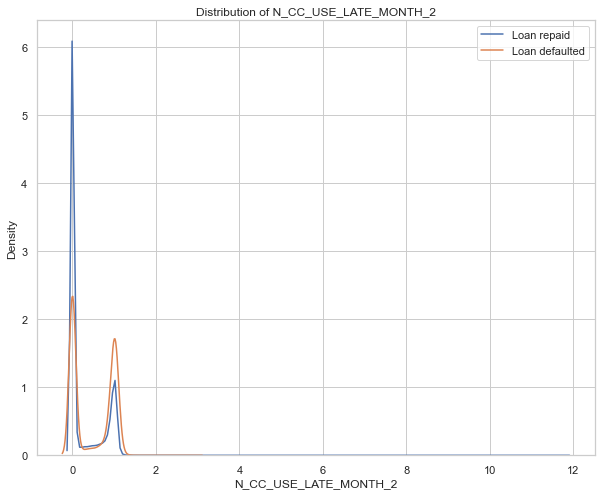

In [79]:
# most interesting feature study through plot
kde_plot(cc_target, 'N_CC_USE_LATE_MONTH_2')

In [80]:
cc_target.isna().sum().head(3)

SK_ID_CURR                    0
TARGET                        0
CC_MONTHS_BALANCE_MIN    220673
dtype: int64

Those cc aggregative data produce missing values once merged with SK_ID, meaning we have no previous internal knowledge about those clients before application according to credit card details.
N_CC_COUNT is therefore zero for those 220606 SK_ID.

## Aggregate "over" Previous credits

There are many inconsistencies between the previous loans and the 3 sources of balance / installments details.

In [81]:
credit_balance_agg.columns

Index(['SK_ID_PREV', 'POS_N_PREV_LOAN_AGE_MONTH', 'POS_N_PREV_LOAN_TERM',
       'POS_N_DPD_PREV_EARLINESS_OVERDUE_RATIO',
       'POS_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO', 'POS_N_PREV_LOAN_AGE'],
      dtype='object')

In [82]:
card_balance_agg.columns

Index(['SK_ID_PREV', 'CC_N_PREV_LOAN_AGE_MONTH', 'CC_N_PREV_LOAN_TERM',
       'CC_N_DPD_PREV_EARLINESS_OVERDUE_RATIO',
       'CC_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO', 'CC_N_PREV_LOAN_AGE'],
      dtype='object')

In [83]:
# prepare concatenation
credit_balance_agg = credit_balance_agg.rename(
    columns={
        'POS_N_PREV_LOAN_TERM': 'NC_LOAN_TERM',
        'POS_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO': 'NC_EARLINESS_OVERDUE_RATIO',
        'POS_N_DPD_PREV_EARLINESS_OVERDUE_RATIO': 'NC_EARLINESS_OVERDUE_RATIO_DEF',
        'POS_N_PREV_LOAN_AGE': 'NC_LOAN_AGE'})
credit_balance_agg.drop(
    ['POS_N_PREV_LOAN_AGE_MONTH'],
    axis= 1,
    inplace = True)
credit_balance_agg.columns

Index(['SK_ID_PREV', 'NC_LOAN_TERM', 'NC_EARLINESS_OVERDUE_RATIO_DEF',
       'NC_EARLINESS_OVERDUE_RATIO', 'NC_LOAN_AGE'],
      dtype='object')

5:80: E501 line too long (83 > 79 characters)
6:80: E501 line too long (83 > 79 characters)
10:10: E251 unexpected spaces around keyword / parameter equals
11:12: E251 unexpected spaces around keyword / parameter equals
11:14: E251 unexpected spaces around keyword / parameter equals


In [84]:
# prepare concatenation
card_balance_agg = card_balance_agg.rename(
    columns={
        'CC_N_PREV_LOAN_TERM': 'NC_LOAN_TERM',
        'CC_N_DPD_PREV_EARLINESS_OVERDUE_RATIO': 'NC_EARLINESS_OVERDUE_RATIO',
        'CC_N_DPD_DEF_PREV_EARLINESS_OVERDUE_RATIO': 'NC_EARLINESS_OVERDUE_RATIO_DEF',
        'CC_N_PREV_LOAN_AGE': 'NC_LOAN_AGE'})
card_balance_agg.drop(
    ['CC_N_PREV_LOAN_AGE_MONTH'],
    axis= 1,
    inplace = True)
card_balance_agg.columns

Index(['SK_ID_PREV', 'NC_LOAN_TERM', 'NC_EARLINESS_OVERDUE_RATIO',
       'NC_EARLINESS_OVERDUE_RATIO_DEF', 'NC_LOAN_AGE'],
      dtype='object')

6:80: E501 line too long (86 > 79 characters)
10:10: E251 unexpected spaces around keyword / parameter equals
11:12: E251 unexpected spaces around keyword / parameter equals
11:14: E251 unexpected spaces around keyword / parameter equals


In [85]:
# perform concat
balance_agg = pd.concat([card_balance_agg, credit_balance_agg])

In [86]:
del card_balance_agg
del credit_balance_agg

In [87]:
# clean features
balance_agg['NC_EARLINESS_OVERDUE_RATIO'] = balance_agg['NC_EARLINESS_OVERDUE_RATIO'].apply(lambda x: x if x > 0 else 0)
balance_agg['NC_EARLINESS_OVERDUE_RATIO_DEF'] = balance_agg['NC_EARLINESS_OVERDUE_RATIO_DEF'].apply(lambda x: x if x > 0 else 0)

2:80: E501 line too long (120 > 79 characters)
3:80: E501 line too long (128 > 79 characters)


In [88]:
# load previous
with open("Data/previous.pkl", mode="rb") as df:
    previous = pickle.load(df)

In [89]:
# merge balance_agg of loans data as a first aggregation step
previous = previous.merge(balance_agg, how='left', on='SK_ID_PREV')

In [90]:
previous.shape

(1344605, 40)

In [91]:
del balance_agg

In [92]:
# manual FE
previous['DAYS_DUE_GAP'] = previous['DAYS_FIRST_DUE'] - previous['DAYS_LAST_DUE_1ST_VERSION']
previous['AMT_CREDIT'].replace(0, np.nan, inplace=True)
previous['AMT_APPLICATION'].replace(0, np.nan, inplace=True)
previous['AMT_GOODS_PRICE'].replace(0, np.nan, inplace=True)
# Days 365.243 values -> nan
previous['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
previous['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
previous['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
previous['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
previous['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
# Add feature: value ask / value received percentage
previous['N_APP_CREDIT_RATIO'] = previous['AMT_APPLICATION'] / previous['AMT_CREDIT']
previous['N_ADJ_CREDIT_RATIO'] = (previous['AMT_APPLICATION'] - previous['AMT_CREDIT']) / previous['AMT_APPLICATION']
previous['N_ADJ_INTEREST_EVAL'] = (previous['AMT_CREDIT'] -  previous['AMT_GOODS_PRICE']) / previous['AMT_GOODS_PRICE']
previous['N_CREDIT_PROLONG_RATIO'] = (previous['DAYS_LAST_DUE'] - previous['DAYS_LAST_DUE_1ST_VERSION']) / (previous['DAYS_DUE_GAP'] - 1)

2:80: E501 line too long (93 > 79 characters)
7:64: E251 unexpected spaces around keyword / parameter equals
8:60: E251 unexpected spaces around keyword / parameter equals
9:71: E251 unexpected spaces around keyword / parameter equals
10:59: E251 unexpected spaces around keyword / parameter equals
11:62: E251 unexpected spaces around keyword / parameter equals
13:80: E501 line too long (85 > 79 characters)
14:80: E501 line too long (117 > 79 characters)
15:60: E222 multiple spaces after operator
15:80: E501 line too long (119 > 79 characters)
16:80: E501 line too long (137 > 79 characters)


In [93]:
# Preprocess previous_applications.csv
def previous_applications(prev, num_rows = None, nan_as_category = True):
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'N_APP_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
        'N_ADJ_CREDIT_RATIO': ['min', 'max', 'mean', 'var'],
        'N_ADJ_INTEREST_EVAL': ['min', 'max', 'mean', 'var'],
        'N_CREDIT_PROLONG_RATIO': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum', 'var'],
        'NC_LOAN_TERM': ['min', 'max', 'mean', 'sum', 'var'],
        'NC_EARLINESS_OVERDUE_RATIO': ['min', 'max', 'mean', 'sum', 'var'],
        'NC_EARLINESS_OVERDUE_RATIO_DEF': ['min', 'max', 'mean', 'sum', 'var'],
        'NC_LOAN_AGE': ['min', 'max', 'mean', 'sum', 'var'],
        'NFLAG_INSURED_ON_APPROVAL': ['sum', 'mean']
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    return prev_agg

2:41: E251 unexpected spaces around keyword / parameter equals
2:43: E251 unexpected spaces around keyword / parameter equals
2:65: E251 unexpected spaces around keyword / parameter equals
2:67: E251 unexpected spaces around keyword / parameter equals
3:60: E251 unexpected spaces around keyword / parameter equals
28:1: W293 blank line contains whitespace
29:80: E501 line too long (87 > 79 characters)
30:80: E501 line too long (105 > 79 characters)
34:80: E501 line too long (117 > 79 characters)
39:80: E501 line too long (114 > 79 characters)


In [94]:
# Preprocess previous_applications.csv
sk_id_previous = previous_applications(previous, num_rows=None)

In [95]:
del previous

Your selected dataframe has 354 columns.
There are 177 columns that have missing values.


<AxesSubplot:>

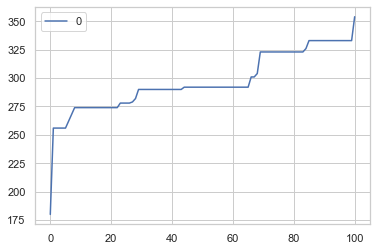

6:80: E501 line too long (112 > 79 characters)


In [96]:
# check for missing values
missing_values = missing_values_table(sk_id_previous)
# get the missing curve
missing_list = []
for i in np.arange(0, 101, 1):
    missing = sk_id_previous.shape[1] - len(list(missing_values.index[missing_values['% of Total Values'] > i]))
    missing_list.append(missing)
pd.DataFrame(missing_list).plot()

In [97]:
def remove_missing_col(df, threshold=90):
    miss_data = pd.DataFrame((df.isnull().sum()) * 100 / df.shape[0])
    miss_data_col = miss_data[miss_data[0] > threshold].index
    data_new = df[[i for i in df.columns if i not in miss_data_col]]
    return data_new

In [98]:
sk_id_previous_clean = remove_missing_col(sk_id_previous)

## Aggregate over Bureau & Bureau_balance

We compute info from bureau_balance

In [99]:
# load previous
with open("Data/bureau.pkl", mode="rb") as df:
    bureau = pickle.load(df)

In [100]:
# third level
bureau_balance = pd.read_csv('Data/bureau_balance.csv')

In [101]:
# to get earliness of overdue we need to catch min of MONTHS_BALANCE out of !=C, X, or 0 STATUS
focus_bureau_balance = bureau_balance[bureau_balance['STATUS'] != 'C']
focus_bureau_balance = focus_bureau_balance[focus_bureau_balance['STATUS'] != 'X']
focus_bureau_balance = focus_bureau_balance[focus_bureau_balance['STATUS'] != '0']
focus_bureau_balance_agg = focus_bureau_balance.groupby(
    'SK_ID_BUREAU',
    as_index=False).agg(
    {'MONTHS_BALANCE': ['min']})
focus_bureau_balance_agg.columns = [
    'SK_ID_BUREAU',
    'N_BUR_EARLIER_OVERDUE']
bureau = bureau.merge(focus_bureau_balance_agg, how='left', on='SK_ID_BUREAU')

1:80: E501 line too long (95 > 79 characters)
3:80: E501 line too long (82 > 79 characters)
4:80: E501 line too long (82 > 79 characters)


In [102]:
# get credit AGE in months since closure
closing_bureau_balance = bureau_balance[bureau_balance['STATUS'] == 'C']
closing_bureau_balance_agg = closing_bureau_balance.groupby(
    'SK_ID_BUREAU',
    as_index=False).agg(
    {'STATUS': ['count']})
closing_bureau_balance_agg.columns = [
    'SK_ID_BUREAU',
    'N_CREDIT_CLOSING_MONTHS']
bureau = bureau.merge(closing_bureau_balance_agg, how='left', on='SK_ID_BUREAU')

10:80: E501 line too long (80 > 79 characters)


In [103]:
del closing_bureau_balance_agg

In [104]:
# to get duration of bureau credit 
term_bureau_balance = bureau_balance[bureau_balance['STATUS'] != 'C']
term_bureau_balance = term_bureau_balance[term_bureau_balance['STATUS'] != 'X']
term_bureau_balance_agg = term_bureau_balance.groupby(
    'SK_ID_BUREAU',
    as_index=False).agg(
    {'MONTHS_BALANCE': ['min']})
term_bureau_balance_agg.columns = [
    'SK_ID_BUREAU',
    'N_BUR_START_OBSERVED']
bureau = bureau.merge(term_bureau_balance_agg, how='left', on='SK_ID_BUREAU')

1:35: W291 trailing whitespace


In [105]:
del term_bureau_balance_agg

In [106]:
# about earlier overdue
bureau['N_BUR_EARLINESS_OVERDUE_RATIO'] = bureau['N_BUR_EARLIER_OVERDUE'] / bureau['N_BUR_START_OBSERVED']
bureau.drop(columns=['N_BUR_EARLIER_OVERDUE'], inplace=True)
bureau['N_BUR_EARLINESS_OVERDUE_RATIO'].fillna(0, inplace=True)
bureau['N_BUR_AMT_CREDIT_DEBT_RATE'] = bureau['AMT_CREDIT_SUM_DEBT'] / (1 + bureau['AMT_CREDIT_SUM'])

2:80: E501 line too long (106 > 79 characters)
5:80: E501 line too long (101 > 79 characters)


In [107]:
# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(bureau, bb, num_rows = None, nan_as_category = True):
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category) 
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    print(bb_aggregations)
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['max', 'mean', 'sum'],
        'AMT_ANNUITY':  ['max', 'mean', 'sum'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'N_CREDIT_CLOSING_MONTHS': ['max', 'mean'],
        'N_BUR_START_OBSERVED' : ['min', 'max', 'mean', 'sum', 'var'],
        'N_BUR_EARLINESS_OVERDUE_RATIO': ['min', 'max', 'mean', 'sum', 'var'],
        'N_BUR_AMT_CREDIT_DEBT_RATE': ['min', 'max', 'mean', 'sum', 'var']       
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BUR_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    return bureau_agg

2:44: E251 unexpected spaces around keyword / parameter equals
2:46: E251 unexpected spaces around keyword / parameter equals
2:68: E251 unexpected spaces around keyword / parameter equals
2:70: E251 unexpected spaces around keyword / parameter equals
4:66: W291 trailing whitespace
11:80: E501 line too long (91 > 79 characters)
13:51: E251 unexpected spaces around keyword / parameter equals
31: E203 whitespace before ':'
32:75: W291 trailing whitespace
36:26: E701 multiple statements on one line (colon)
37:22: E701 multiple statements on one line (colon)
38:80: E501 line too long (91 > 79 characters)
39:80: E501 line too long (108 > 79 characters)
43:80: E501 line too long (111 > 79 characters)
48:80: E501 line too long (111 > 79 characters)


In [108]:
# Preprocess bureau.csv and bureau_balance.csv
sk_id_bureau = bureau_and_balance(bureau, bureau_balance, num_rows=None)

{'MONTHS_BALANCE': ['min', 'max', 'size'], 'STATUS_0': ['mean'], 'STATUS_1': ['mean'], 'STATUS_2': ['mean'], 'STATUS_3': ['mean'], 'STATUS_4': ['mean'], 'STATUS_5': ['mean'], 'STATUS_C': ['mean'], 'STATUS_X': ['mean'], 'STATUS_nan': ['mean']}


In [109]:
del bureau
del bureau_balance

Your selected dataframe has 169 columns.
There are 135 columns that have missing values.


<AxesSubplot:>

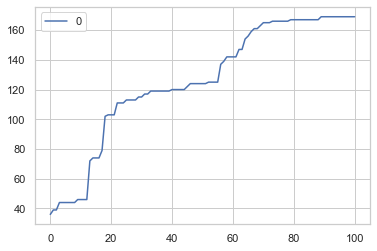

6:80: E501 line too long (110 > 79 characters)


In [110]:
# check for missing values
missing_values = missing_values_table(sk_id_bureau)
# get the missing curve
missing_list = []
for i in np.arange(0, 101, 1):
    missing = sk_id_bureau.shape[1] - len(list(missing_values.index[missing_values['% of Total Values'] > i]))
    missing_list.append(missing)
pd.DataFrame(missing_list).plot()

## Treat Applications
We proceed with manual FE on any applicant's profile

In [111]:
with open("Data/any_app.pkl", mode="rb") as df:
    any_applications = pickle.load(df)

In [112]:
# Preprocess application_train.csv and application_test.csv
def application_train_test(df, num_rows=None, nan_as_category=False): 
    # Categorical features with Binary encode (0 or 1; two categories)
    df = label_encoder(df)
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    return df, cat_cols

2:70: W291 trailing whitespace


In [113]:
# Preprocess application_train.csv and application_test.csv
application, catApp = application_train_test(any_applications, num_rows=None)

4 columns were label encoded. ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']


In [114]:
del any_applications

In [115]:
# merge to target for corr study
app_target = application[application['TARGET'].notna()]
app_target_corrs = target_corrs(app_target)

In [116]:
app_target_corrs.head(10)

,feature,abs_corr
120,N_REJECT_RATE,0.078596
124,YEARS_BIRTH,0.078242
11,DAYS_EMPLOYED,0.074957
125,N_DAYS_EMPLOYED_RATIO,0.067952
117,N_ADJ_REJECT_INDEX,0.064858
115,N_FLAG_REJECTED,0.063833
23,REGION_RATING_CLIENT_W_CITY,0.060895
22,REGION_RATING_CLIENT,0.058901
144,NAME_INCOME_TYPE_Working,0.057483
146,NAME_EDUCATION_TYPE_Higher education,0.056593


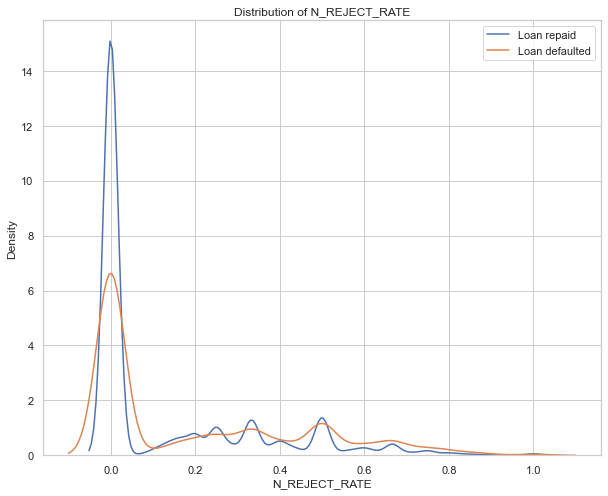

In [117]:
# most interesting feature study through plot
kde_plot(app_target, 'N_REJECT_RATE')

Your selected dataframe has 281 columns.
There are 58 columns that have missing values.


<AxesSubplot:>

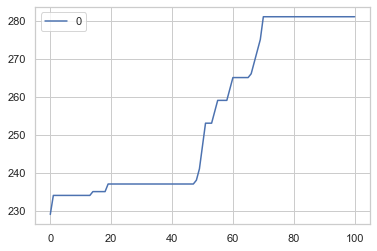

6:80: E501 line too long (109 > 79 characters)


In [118]:
# check for missing values
missing_values = missing_values_table(application)
# get the missing curve
missing_list = []
for i in np.arange(0, 101, 1):
    missing = application.shape[1] - len(list(missing_values.index[missing_values['% of Total Values'] > i]))
    missing_list.append(missing)
pd.DataFrame(missing_list).plot()

# Merge any applicant's knowledge

## Optimize df size

In [119]:
'''
print('application :')
application = convert_types(application, print_info=True)
print('sk_id_bureau :')
sk_id_bureau = convert_types(sk_id_bureau, print_info=True)
print('sk_id_previous_clean :')
sk_id_previous_clean = convert_types(sk_id_previous_clean, print_info=True)
print('sk_id_focus_credit_balance :')
sk_id_focus_credit_balance = convert_types(sk_id_focus_credit_balance, print_info=True)
print('sk_id_card_balance :')
sk_id_card_balance = convert_types(sk_id_card_balance, print_info=True)
print('sk_id_installments :')
sk_id_installments = convert_types(sk_id_installments, print_info=True)
print('sk_id_installments_agg :')
sk_id_installments_agg = convert_types(sk_id_installments_agg, print_info=True)
'''

"\nprint('application :')\napplication = convert_types(application, print_info=True)\nprint('sk_id_bureau :')\nsk_id_bureau = convert_types(sk_id_bureau, print_info=True)\nprint('sk_id_previous_clean :')\nsk_id_previous_clean = convert_types(sk_id_previous_clean, print_info=True)\nprint('sk_id_focus_credit_balance :')\nsk_id_focus_credit_balance = convert_types(sk_id_focus_credit_balance, print_info=True)\nprint('sk_id_card_balance :')\nsk_id_card_balance = convert_types(sk_id_card_balance, print_info=True)\nprint('sk_id_installments :')\nsk_id_installments = convert_types(sk_id_installments, print_info=True)\nprint('sk_id_installments_agg :')\nsk_id_installments_agg = convert_types(sk_id_installments_agg, print_info=True)\n"

9:80: E501 line too long (87 > 79 characters)
16:80: E501 line too long (724 > 79 characters)


## Merge data & save

In [120]:
# check for missing values
missing_values = missing_values_table(application)

Your selected dataframe has 281 columns.
There are 58 columns that have missing values.


In [121]:
print("initial shape:", application.shape)
application = application.merge(sk_id_bureau, how='left', on='SK_ID_CURR')
print("with sk_id_bureau:", application.shape)

initial shape: (356251, 281)
with sk_id_bureau: (356251, 450)


In [122]:
# check for missing values
missing_values = missing_values_table(application)

Your selected dataframe has 450 columns.
There are 227 columns that have missing values.


In [123]:
del sk_id_bureau

In [124]:
application = application.merge(sk_id_previous_clean, how='left', on='SK_ID_CURR')
print("with sk_id_previous_clean:", application.shape)

with sk_id_previous_clean: (356251, 783)


1:80: E501 line too long (82 > 79 characters)


In [125]:
# check for missing values
missing_values = missing_values_table(application)

Your selected dataframe has 783 columns.
There are 560 columns that have missing values.


In [126]:
del sk_id_previous_clean

In [127]:
application = application.merge(sk_id_installments_agg, how='left', on='SK_ID_CURR')
print("with sk_id_installments_agg agg", application.shape)

1:80: E501 line too long (84 > 79 characters)


with sk_id_installments_agg agg (356251, 813)


In [128]:
# check for missing values
missing_values = missing_values_table(application)

Your selected dataframe has 813 columns.
There are 590 columns that have missing values.


In [129]:
del sk_id_installments_agg

In [130]:
application = application.merge(sk_id_installments, how='left', on='SK_ID_CURR')
print("with installments agg", application.shape)

with installments agg (356251, 830)


1:80: E501 line too long (80 > 79 characters)


In [131]:
# check for missing values
missing_values = missing_values_table(application)

Your selected dataframe has 830 columns.
There are 607 columns that have missing values.


In [132]:
del sk_id_installments

In [133]:
application = application.merge(sk_id_credit_balance, how='left', on='SK_ID_CURR')
print("with credit balance agg", application.shape)

with credit balance agg (356251, 839)


1:80: E501 line too long (82 > 79 characters)


In [134]:
# check for missing values
missing_values = missing_values_table(application)

Your selected dataframe has 839 columns.
There are 616 columns that have missing values.


In [135]:
del sk_id_credit_balance

In [136]:
application = application.merge(sk_id_card_balance, how='left', on='SK_ID_CURR')
print("with card balance agg", application.shape)

with card balance agg (356251, 942)


1:80: E501 line too long (80 > 79 characters)


In [137]:
# check for missing values
missing_values = missing_values_table(application)

Your selected dataframe has 942 columns.
There are 719 columns that have missing values.


In [138]:
del sk_id_card_balance

In [139]:
columns = application.columns.tolist()
key = 'SK_ID'
cols_with_sk_id = [item for item in columns if key in item]
print(cols_with_sk_id)

['SK_ID_CURR']


In [144]:
with open("Data/application_miss.pkl", mode="wb") as df:
    pickle.dump(application, df)

In [140]:
STOP

NameError: name 'STOP' is not defined

## Examine Missing Values

Next we can look at the number and percentage of missing values in each column. 

In [141]:
# check for missing values
missing_values = missing_values_table(application)

Your selected dataframe has 942 columns.
There are 719 columns that have missing values.


In [142]:
missing_values

,Missing Values,% of Total Values
ACTIVE_N_CREDIT_CLOSING_MONTHS_MEAN,320144,89.9
ACTIVE_N_CREDIT_CLOSING_MONTHS_MAX,320144,89.9
REFUSED_RATE_DOWN_PAYMENT_MAX,303649,85.2
REFUSED_RATE_DOWN_PAYMENT_MIN,303649,85.2
REFUSED_AMT_DOWN_PAYMENT_MEAN,303649,85.2
REFUSED_AMT_DOWN_PAYMENT_MAX,303649,85.2
REFUSED_RATE_DOWN_PAYMENT_MEAN,303649,85.2
REFUSED_AMT_DOWN_PAYMENT_MIN,303649,85.2
REFUSED_CNT_PAYMENT_VAR,302445,84.9
REFUSED_N_ADJ_INTEREST_EVAL_VAR,301273,84.6


<AxesSubplot:>

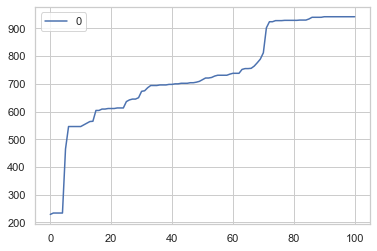

4:80: E501 line too long (109 > 79 characters)


In [143]:
# get the missing curve
missing_list = []
for i in np.arange(0, 101, 1):
    missing = application.shape[1] - len(list(missing_values.index[missing_values['% of Total Values'] > i]))
    missing_list.append(missing)
pd.DataFrame(missing_list).plot()

A first set of features can be safely removed and is the result of wrong aggregation method during "automated" FE.

In [ ]:
# get the list of features to remove
remove_missing = list(missing_values.index[missing_values['% of Total Values'] > 85])

In [ ]:
remove_missing

In [ ]:
application.drop(columns=remove_missing, inplace=True)

In [ ]:
STOP

# Global feature selection

## "Model agnostic" Boruta Feature Selection

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [ ]:
# keep training applications only
train = application[application['TARGET'].notna()]

In [ ]:
# set index with SK_ID_CURR
train = train.set_index('SK_ID_CURR')

In [ ]:
X_ = train.drop(columns=['TARGET'])
y_ = train['TARGET']

In [ ]:
X_sample, _, y_sample, _ = train_test_split(
        X_,
        y_,
        stratify=y_,
        test_size=0.8,
        random_state=42)

In [ ]:
imputer = SimpleImputer(
    missing_values=np.nan,
    strategy='mean')
imputer.fit(X_sample)
X_sample = imputer.transform(X_sample)

In [ ]:
# define random forest classifier, with utilising all cores and
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=6)

In [ ]:
# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators='auto', max_iter=15, verbose=2, random_state=1)

In [ ]:
# find all relevant features - features should be selected
feat_selector.fit(X_sample, y_sample)

In [ ]:
pd.options.display.max_rows = 999

In [ ]:
x = train.drop(columns=['TARGET']).columns
y = feat_selector.ranking_
df = pd.DataFrame({'feature': x, 'rank': y})
df = df.sort_values(by=['rank'], ascending=True)
df

In [ ]:
# get support features
support = train.drop(columns=['TARGET']).columns[feat_selector.support_]

In [ ]:
selected = []
selected = ['SK_ID_CURR'] + ['TARGET'] + support.tolist()

In [ ]:
sel_app = application.filter(selected)

In [ ]:
with open("Data/sel_app.pkl", mode="wb") as df:
    pickle.dump(sel_app, df)

In [ ]:
del sel_app
del train
del application